<a href="https://colab.research.google.com/github/Draconov/hwhrec/blob/main/HHD_Classifier_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Handwritten Hebrew Letter Classifier
This notebook walks through the full process of classifying handwritten Hebrew letters using a feedforward neural network.

**Steps:**
1. Environment Setup
2. Extract and Preprocess Dataset
3. Split and Save Preprocessed Images
4. Load Images using OpenCV
5. Build and Train Neural Network
6. Evaluate Performance
7. Save Results

In [ ]:
# 📦 Imports
import numpy as np
import cv2
import os
import zipfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import seaborn as sns

## 📁 1. Extract Dataset

In [ ]:
from google.colab import files
files.upload()  # Then choose your correct hhd.zip

import zipfile
import os

os.makedirs("hhd_dataset", exist_ok=True)

with zipfile.ZipFile("hhd.zip", 'r') as zip_ref:
    zip_ref.extractall("hhd_dataset")

Saving hhd.zip to hhd.zip


## 🧼 2. Preprocess Images with OpenCV

In [ ]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    h, w = img.shape
    if h > w:
        diff = h - w
        pad_left = diff // 2
        pad_right = diff - pad_left
        img = cv2.copyMakeBorder(img, 0, 0, pad_left, pad_right, cv2.BORDER_CONSTANT, value=255)
    elif w > h:
        diff = w - h
        pad_top = diff // 2
        pad_bottom = diff - pad_top
        img = cv2.copyMakeBorder(img, pad_top, pad_bottom, 0, 0, cv2.BORDER_CONSTANT, value=255)
    img = cv2.resize(img, (32, 32))
    img = 255 - img
    return img

## 🧪 3. Split Dataset and Save into Train/Val/Test Folders

In [ ]:
import shutil
from sklearn.model_selection import train_test_split

# Step 1: Collect all image paths and their labels
image_paths = []
labels = []

dataset_dir = "hhd_dataset"  # This is the folder where you extracted the zip

for label in sorted(os.listdir(dataset_dir), key=lambda x: int(x)):
    class_dir = os.path.join(dataset_dir, label)
    if not os.path.isdir(class_dir):
        continue
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_dir, fname))
            labels.append(int(label))

# Step 2: Split into train, val, test
X_temp, X_test, y_temp, y_test = train_test_split(image_paths, labels, test_size=0.1, stratify=labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, stratify=y_temp, random_state=42)  # 10% of original for val

# Step 3: Helper to save images
def save_split(images, labels, base_dir):
    for img_path, label in zip(images, labels):
        out_dir = os.path.join(base_dir, str(label))
        os.makedirs(out_dir, exist_ok=True)
        shutil.copy(img_path, os.path.join(out_dir, os.path.basename(img_path)))

# Step 4: Create directories and copy files
save_split(X_train, y_train, "processed_hhd/train")
save_split(X_val, y_val, "processed_hhd/val")
save_split(X_test, y_test, "processed_hhd/test")

## 📥 4. Load Dataset from Preprocessed Folders

In [ ]:
def load_dataset_from_folder(base_dir):
    import cv2
    import numpy as np
    import os

    X = []
    y = []

    for class_idx in range(27):
        class_folder = os.path.join(base_dir, str(class_idx))
        if not os.path.exists(class_folder):
            continue

        for fname in os.listdir(class_folder):
            fpath = os.path.join(class_folder, fname)

            img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)

            if img is None:
                print(f"❌ Skipping unreadable image: {fpath}")
                continue

            # Resize to 32x32 if not already
            if img.shape != (32, 32):
                img = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)

            img = 255 - img  # negative
            img = img.astype(np.float32) / 255.0  # normalize to [0, 1]
            img = img.flatten()  # flatten to shape (1024,)

            X.append(img)
            y.append(class_idx)

    X = np.array(X)
    y = np.array(y)

    print(f"✅ Loaded from {base_dir} → X shape: {X.shape}, y shape: {y.shape}")
    return X, y

X_train, y_train = load_dataset_from_folder("processed_hhd/train")
X_val, y_val     = load_dataset_from_folder("processed_hhd/val")
X_test, y_test   = load_dataset_from_folder("processed_hhd/test")

✅ Loaded from processed_hhd/train → X shape: (4044, 1024), y shape: (4044,)
✅ Loaded from processed_hhd/val → X shape: (506, 1024), y shape: (506,)
✅ Loaded from processed_hhd/test → X shape: (506, 1024), y shape: (506,)


## 🧠 5. Build and Train Feedforward Neural Network

In [ ]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(1024,)),
    Dense(512, activation='relu'),
    Dense(27, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32)

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4269 - loss: 2.0590 - val_accuracy: 0.7194 - val_loss: 1.0126
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7481 - loss: 0.8328 - val_accuracy: 0.7352 - val_loss: 0.8986
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8158 - loss: 0.6268 - val_accuracy: 0.7510 - val_loss: 0.8396
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8711 - loss: 0.4456 - val_accuracy: 0.7589 - val_loss: 0.8174
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8964 - loss: 0.3257 - val_accuracy: 0.7569 - val_loss: 0.8258
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9137 - loss: 0.2575 - val_accuracy: 0.7727 - val_loss: 0.8399
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9491 - loss: 0.1833 - val_accuracy: 0.7648 - val_loss: 0.8797
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9571 - loss: 0.1455 - val_accu

## 📊 6. Evaluate and Save Results

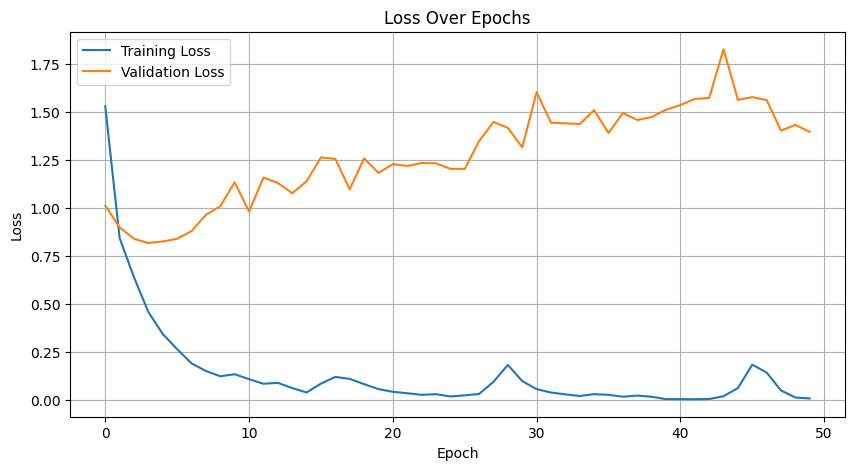

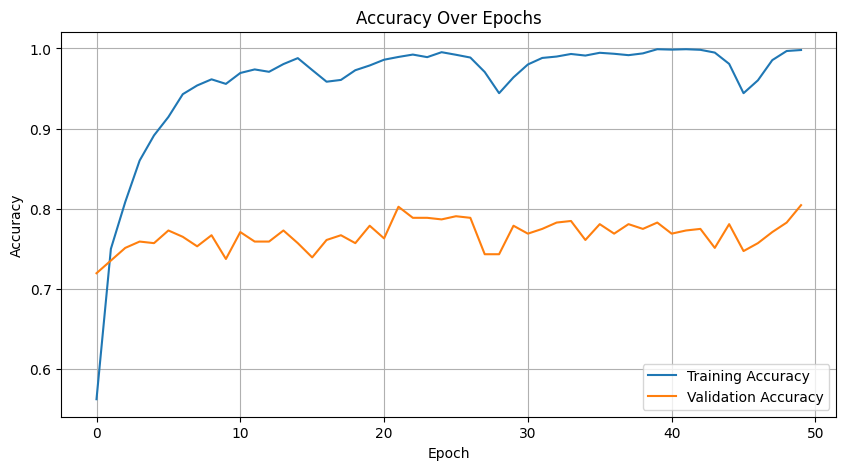

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7931 - loss: 1.3138
Test Accuracy: 0.7648, Test Loss: 1.4661
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


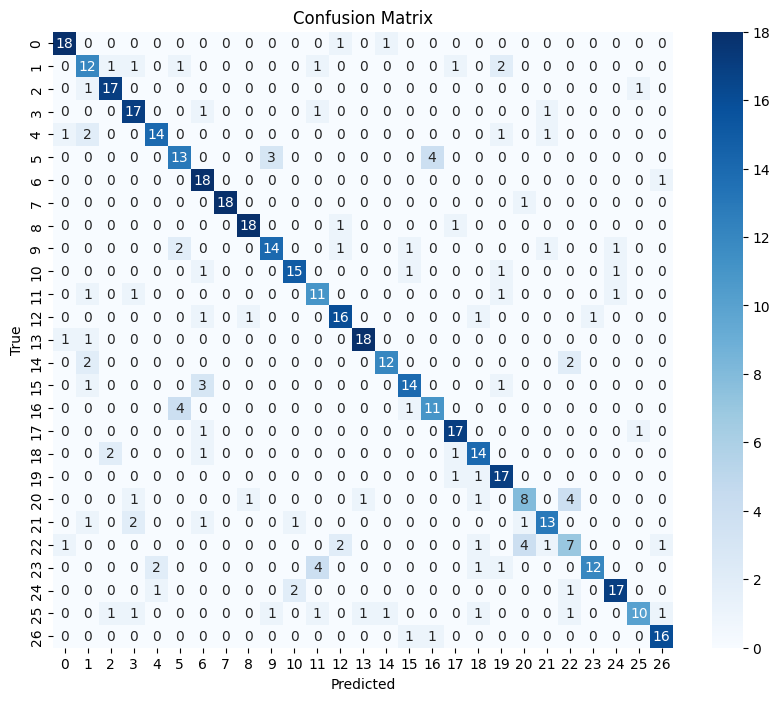

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.savefig("accuracy_curve.png")
plt.show()

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_labels)
cm_df = pd.DataFrame(cm)
cm_df.to_csv("confusion_matrix.csv", index=False)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.savefig("confusion_matrix.png")
plt.show()

letter_accuracies = cm.diagonal() / cm.sum(axis=1)

with open("results.txt", "w") as f:
    f.write("Letter    Accuracy\n")
    for i, acc in enumerate(letter_accuracies):
        f.write(f"{i:<10}{acc:.4f}\n")
    f.write(f"{'-'*18}\n")
    f.write(f"Avg       {np.mean(letter_accuracies):.4f}\n")